# STEP 4 - Making DRL PySC2 Agent

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import sys; sys.path.append('..')

In [69]:
### unfortunately, PySC2 uses Abseil, which treats python code as if its run like an app
# This does not play well with jupyter notebook
# So we will need to monkeypatch sys.argv


import sys
#sys.argv = ["python", "--map", "AbyssalReef"]
sys.argv = ["python", "--map", "Simple64"]

## 0. Runnning 'Agent code' on jupyter notebook 

In [83]:


# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS-IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Run an agent."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import threading

from absl import app
from absl import flags
from future.builtins import range  # pylint: disable=redefined-builtin

from pysc2 import maps
from pysc2.env import available_actions_printer
from pysc2.env import run_loop
from pysc2.env import sc2_env
from pysc2.lib import point_flag
from pysc2.lib import stopwatch
from pysc2.lib import actions

FLAGS = flags.FLAGS

# because of Abseil's horrible design for running code underneath Colabs
# We have to pull out this ugly hack from the hat
if "flags_defined" not in globals():
    flags.DEFINE_bool("render", False, "Whether to render with pygame.")
    point_flag.DEFINE_point("feature_screen_size", "84",
                            "Resolution for screen feature layers.")
    point_flag.DEFINE_point("feature_minimap_size", "64",
                            "Resolution for minimap feature layers.")
    point_flag.DEFINE_point("rgb_screen_size", None,
                            "Resolution for rendered screen.")
    point_flag.DEFINE_point("rgb_minimap_size", None,
                            "Resolution for rendered minimap.")
    flags.DEFINE_enum("action_space", "RAW", sc2_env.ActionSpace._member_names_,  # pylint: disable=protected-access
                      "Which action space to use. Needed if you take both feature "
                      "and rgb observations.")
    flags.DEFINE_bool("use_feature_units", False,
                      "Whether to include feature units.")
    flags.DEFINE_bool("use_raw_units", True,
                      "Whether to include raw units.")
    flags.DEFINE_integer("raw_resolution", 64, "Raw Resolution.")
    flags.DEFINE_bool("disable_fog", True, "Whether to disable Fog of War.")

    flags.DEFINE_integer("max_agent_steps", 0, "Total agent steps.")
    flags.DEFINE_integer("game_steps_per_episode", None, "Game steps per episode.")
    flags.DEFINE_integer("max_episodes", 0, "Total episodes.")
    flags.DEFINE_integer("step_mul", 8, "Game steps per agent step.")
    flags.DEFINE_float("fps", 22.4, "Frames per second to run the game.")

    #flags.DEFINE_string("agent", "sc2.agent.BasicAgent.ZergBasicAgent",
    #                    "Which agent to run, as a python path to an Agent class.")
    #flags.DEFINE_enum("agent_race", "zerg", sc2_env.Race._member_names_,  # pylint: disable=protected-access
    #                  "Agent 1's race.")
    flags.DEFINE_string("agent", "TerranRLAgentWithRawActsAndRawObs",
                        "Which agent to run, as a python path to an Agent class.")
    flags.DEFINE_enum("agent_race", "terran", sc2_env.Race._member_names_,  # pylint: disable=protected-access
                      "Agent 1's race.")

    flags.DEFINE_string("agent2", "Bot", "Second agent, either Bot or agent class.")
    flags.DEFINE_enum("agent2_race", "random", sc2_env.Race._member_names_,  # pylint: disable=protected-access
                      "Agent 2's race.")
    flags.DEFINE_enum("difficulty", "hard", sc2_env.Difficulty._member_names_,  # pylint: disable=protected-access
                      "If agent2 is a built-in Bot, it's strength.")

    flags.DEFINE_bool("profile", False, "Whether to turn on code profiling.")
    flags.DEFINE_bool("trace", False, "Whether to trace the code execution.")
    flags.DEFINE_integer("parallel", 1, "How many instances to run in parallel.")

    flags.DEFINE_bool("save_replay", True, "Whether to save a replay at the end.")

    flags.DEFINE_string("map", None, "Name of a map to use.")
    flags.mark_flag_as_required("map")

flags_defined = True

def run_thread(agent_classes, players, map_name, visualize):
  """Run one thread worth of the environment with agents."""
  with sc2_env.SC2Env(
      map_name=map_name,
      players=players,
      agent_interface_format=sc2_env.parse_agent_interface_format(
        feature_screen=FLAGS.feature_screen_size,
        feature_minimap=FLAGS.feature_minimap_size,
        rgb_screen=FLAGS.rgb_screen_size,
        rgb_minimap=FLAGS.rgb_minimap_size,
        action_space=FLAGS.action_space,
        use_raw_units=FLAGS.use_raw_units,
        raw_resolution=FLAGS.raw_resolution),
      step_mul=FLAGS.step_mul,
      game_steps_per_episode=FLAGS.game_steps_per_episode,
      disable_fog=FLAGS.disable_fog,
      visualize=visualize) as env:
    #env = available_actions_printer.AvailableActionsPrinter(env)
    agents = [agent_cls() for agent_cls in agent_classes]
    run_loop.run_loop(agents, env, FLAGS.max_agent_steps, FLAGS.max_episodes)
    if FLAGS.save_replay:
      env.save_replay(agent_classes[0].__name__)

def main(unused_argv):
  """Run an agent."""
  #stopwatch.sw.enabled = FLAGS.profile or FLAGS.trace
  #stopwatch.sw.trace = FLAGS.trace

  map_inst = maps.get(FLAGS.map)

  agent_classes = []
  players = []

  #agent_module, agent_name = FLAGS.agent.rsplit(".", 1)
  #agent_cls = getattr(importlib.import_module(agent_module), agent_name)
  #agent_classes.append(agent_cls)
  agent_classes.append(TerranRLAgentWithRawActsAndRawObs)
  players.append(sc2_env.Agent(sc2_env.Race[FLAGS.agent_race]))

  if map_inst.players >= 2:
    if FLAGS.agent2 == "Bot":
      players.append(sc2_env.Bot(sc2_env.Race[FLAGS.agent2_race],
                                 sc2_env.Difficulty[FLAGS.difficulty]))
    else:
      #agent_module, agent_name = FLAGS.agent2.rsplit(".", 1)
      #agent_cls = getattr(importlib.import_module(agent_module), agent_name)
      agent_classes.append(TerranRandomAgent)
      players.append(sc2_env.Agent(sc2_env.Race[FLAGS.agent2_race]))

  threads = []
  for _ in range(FLAGS.parallel - 1):
    t = threading.Thread(target=run_thread,
                         args=(agent_classes, players, FLAGS.map, False))
    threads.append(t)
    t.start()

  run_thread(agent_classes, players, FLAGS.map, FLAGS.render)

  for t in threads:
    t.join()

  if FLAGS.profile:
    pass
    #print(stopwatch.sw)

## 1. Creating a PySC2 Agent with Raw Actions & Observations

![StarCraft2 PySC2 interfaces](./images/StarCraft2_PySC2_interfaces.png)

ref : https://on-demand.gputechconf.com/gtc/2018/presentation/s8739-machine-learning-with-starcraft-II.pdf

### < PySC2 Interfaces 3가지 종류 >

### 1st, Rendered
* Decomposed :
    - Screen, minimap, resources, available actions
* Same control as humans :
    - Pixel coordinates
    - Move camera
    - Select unit/rectangle
* Great for Deep Learning, but hard

### 2nd, Feature Layer
* Same actions : still in pixel space
* Same decomposed observations, but more abstract
    - Orthogonal camera 
* Layers:
    - unit type
    - unit owner
    - selection
    - health
    - unit density
    - etc
    
### 3rd, Raw
* List of units and state
* Control each unit individually in world coordinates
* Gives all observable state (no camera)
* Great for scripted agents and programmatic replay analysis

### < Raw Actions & Observations 을 사용하는 이유>
* Raw Actions & Observations 은 world cordinates를 사용하므로 전체 Map을 한번에 관찰하고 Camera를 이동하지 않고도 Map 상의 어느 곳에서도 Action을 취할 수 있는 새로운 형태의 Feature 이다.
* 이번 과정에 SL(Supervised Learning, 지도학습)을 활용한 학습은 없지만 스타크래프트 2 리플레이를 활용한 SL은 Raw Actions & Observations를 활용한 "programmatic replay analysis"가 필요하다.
* 인간 플레이어를 이긴 DeepMind의 AlphaStar의 주요 변경사항 중의 하나는 Raw Actions & Observations 의 활용이다.

### DRL 모델의 성능 추이를 보기위해 Reward의 평균 추이를 이용한다. 이때 단순이동평균 보다는 지수이동평균이 적절하다.

### 지수이동평균(EMA:Exponential Moving Average) 란?
지수이동평균(Exponential Moving Average)은 과거의 모든 기간을 계산대상으로 하며 최근의 데이타에 더 높은 가중치를 두는 일종의 가중이동평균법이다.

단순이동평균의 계산법에 비하여 원리가 복잡해 보이지만 실제로 이동평균을 산출하는 방법은 Previous Step의 지수이동평균값과 평활계수(smoothing constant) 그리고 당일의 가격만으로 구할 수 있으므로 Previous Step의 지수이동평균값만 구해진다면 오히려 간단한 편이다.

따라서 지수이동평균은 단순이동평균에 비해 몇가지 중요한 강점을 가진다.

첫째는 가장 최근의 Step에 가장 큰 가중치를 둠으로 해서 최근의 Episode들을 잘 반영한다는 점이고, 둘째는 단순이동평균에서와 같이 오래된 데이타를 갑자기 제외하지 않고 천천히 그 영향력을 사라지게 한다는 점이다.
또한 전 기간의 데이타를 분석대상으로 함으로써 가중이동평균에서 문제되는 특정 기간의 데이타만을 분석대상으로 한다는 단점도 보완하고 있다.

### 지수이동평균(EMA:Exponential Moving Average) 계산

지수이동평균은 가장 최근의 값에 많은 가중치를 부여하고 오래 된 값에는 적은 가중치를 부여한다. 비록 오래 된 값이라고 할지라도 완전히 무시하지는 않고 적게나마 반영시켜 계산한다는 장점이 있다. 단기 변동성을 포착하려는 것이 목적이다.

EMA=Previous Step 지수이동평균+(k∗(Current Step Reward − Previous Step 지수이동평균))


## 3. Applying Vanilla DQN to a PySC2 Agent

구현된 기능

- Implementing 'Experience Replay' : 
    - 'Maximization Bias' 문제를 발생시키는 원인 중 하나인 'Sample간의 시간적 연관성'을 해결하기 위한 방법
    - Online Learning 에서 Batch Learning 으로 학습방법 바뀜 : Online update 는 Batch update 보다 일반적으로 Validation loss 가 더 높게 나타남.
    - Reinforcement Learning for Robots. Using Neural Networks. Long -Ji Lin. January 6, 1993. 논문에서 최초로 연구됨 http://isl.anthropomatik.kit.edu/pdf/Lin1993.pdf

- Implementing 'Fixed Q-Target' : 
    - 'Moving Q-Target' 문제 해결하기 위한 방법
    - 2015년 Nature 버전 DQN 논문에서 처음 제안됨. https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning 


구현되지 않은 기능

- Implementing 'Sensory Input Feature-Extraction' :
    - 게임의 Raw Image 를 Neural Net에 넣기 위한 Preprocessing(전처리) 과정
    - Raw Image 의 Sequence중 '최근 4개의 이미지'(과거 정보)를 하나의 새로운 State로 정의하여 non-MDP를 MDP 문제로 바꾸는 Preprocessing 과정 
    - CNN(합성곱 신경망)을 활용한 '차원의 저주' 극복

In [271]:
import random
import time
import math
import os.path

import numpy as np
import pandas as pd
from collections import deque
import pickle

from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units, upgrades
from absl import app

import torch
from torch.utils.tensorboard import SummaryWriter

from skdrl.pytorch.model.mlp import NaiveMultiLayerPerceptron
from skdrl.common.memory.memory import ExperienceReplayMemory

In [272]:
DATA_FILE_QNET = 'rlagent_with_vanilla_dqn_qnet'
DATA_FILE_QNET_TARGET = 'rlagent_with_vanilla_dqn_qnet_target'
SCORE_FILE = 'rlagent_with_vanilla_dqn_score'

scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

In [273]:
import torch
import torch.nn as nn


class NaiveMultiLayerPerceptron(nn.Module):

    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 num_neurons: list = [64, 32],
                 hidden_act_func: str = 'ReLU',
                 out_act_func: str = 'Identity'):
        super(NaiveMultiLayerPerceptron, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_neurons = num_neurons
        self.hidden_act_func = getattr(nn, hidden_act_func)()
        self.out_act_func = getattr(nn, out_act_func)()

        input_dims = [input_dim] + num_neurons
        output_dims = num_neurons + [output_dim]

        self.layers = nn.ModuleList()
        for i, (in_dim, out_dim) in enumerate(zip(input_dims, output_dims)):
            is_last = True if i == len(input_dims) - 1 else False
            self.layers.append(nn.Linear(in_dim, out_dim))
            if is_last:
                self.layers.append(self.out_act_func)
            else:
                self.layers.append(self.hidden_act_func)

    def forward(self, xs):
        for layer in self.layers:
            xs = layer(xs)
        return xs


if __name__ == '__main__':
    net = NaiveMultiLayerPerceptron(10, 1, [20, 12], 'ReLU', 'Identity')
    print(net)

    xs = torch.randn(size=(12, 10))
    ys = net(xs)
    print(ys)


NaiveMultiLayerPerceptron(
  (hidden_act_func): ReLU()
  (out_act_func): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=1, bias=True)
    (5): Identity()
  )
)
tensor([[-0.3301],
        [-0.4388],
        [-0.4118],
        [-0.3924],
        [-0.3717],
        [-0.4231],
        [-0.4617],
        [-0.3912],
        [-0.3118],
        [-0.3619],
        [-0.3262],
        [-0.4291]], grad_fn=<AddmmBackward>)


### Q-update 공식

#### 1. Online Q-learning
![Online Q-learning](./images/q-update-experience-replay.png)

#### 2. Online Q-learning with Function Approximation
![Online Q-learning with Function Approximation](./images/q-update-function-approximation.png)

#### 3. Batch Q-learning with Function Approximation & Experience Replay
![Batch Q-learning with Function Approximation & Experience Replay](./images/q-update-online.png)

In [274]:
from random import sample


class ExperienceReplayMemory:
    def __init__(self, max_size):
        # deque object that we've used for 'episodic_memory' is not suitable for random sampling
        # here, we instead use a fix-size array to implement 'buffer'
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def push(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]

    def __len__(self):
        return self.size

### Moving target problem

#### 1. Function Approximation을 사용하지 않는 Q-learning 의 경우 : 특정한 Q(s,a) update가 다른 Q(s,a)에 영향을 주지 않는다.
![Moving target Q-learning](./images/moving-target_q-learing_case.png)

#### 2. Function Approximation을 사용하는 Q-learnig 의 경우 : 특정한 Q(s,a) update가 다른 Q(s,a)에 영향을 준다.
![Moving target Q-learning with Function Approximation](./images/moving-target_q-learing_with_function_approximation_case.png)

### Moving target 문제는 Deep Neural Network를 사용하는 Function Approximation 기법인 경우 심해지는 경향성이 있음.

image ref : Fast Campus RL online courese

### `nn.SmoothL1Loss()` = Huber loss 란?

Mean-squared Error (MSE) Loss 는 데이터의 outlier에 매우 취약하다.
어떤 이유로 타겟하는 레이블 y (이 경우는 q-learning target)이 noisy 할때를 가정하면, 잘못된 y 값을 맞추기 위해 파라미터들이 너무 sensitive 하게 움직이게 된다.

이런 현상은 q-learning 의 학습초기에 매우 빈번해 나타난다. 이러한 문제를 조금이라도 완화하기 위해서 outlier에 덜 민감한 Huber loss 함수를 사용한다.

### SmoothL1Loss (aka Huber loss)

$$loss(x,y) = \frac{1}{n}\sum_i z_i$$
$|x_i - y_i| <1$ 일때,
$$z_i = 0.5(x_i - y_i)^2$$
$|x_i - y_i| \geq1$ 일때,
$$z_i = |x_i - y_i|-0.5$$

ref : https://pytorch.org/docs/master/generated/torch.nn.SmoothL1Loss.html

In [275]:
import torch
import torch.nn as nn
import numpy as np
import random

class DQN(nn.Module):

    def __init__(self,
                 state_dim: int,
                 action_dim: int,
                 qnet: nn.Module,
                 qnet_target: nn.Module,
                 lr: float,
                 gamma: float,
                 epsilon: float):
        """
        :param state_dim: input state dimension
        :param action_dim: action dimension
        :param qnet: main q network
        :param qnet_target: target q network
        :param lr: learning rate
        :param gamma: discount factor of MDP
        :param epsilon: E-greedy factor
        """

        super(DQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.qnet = qnet
        self.lr = lr
        self.gamma = gamma
        self.opt = torch.optim.Adam(params=self.qnet.parameters(), lr=lr)
        self.register_buffer('epsilon', torch.ones(1) * epsilon)

        # target network related
        qnet_target.load_state_dict(qnet.state_dict())
        self.qnet_target = qnet_target
        self.criteria = nn.SmoothL1Loss()

    def choose_action(self, state):
        qs = self.qnet(state)
        #prob = np.random.uniform(0.0, 1.0, 1)
        #if torch.from_numpy(prob).float() <= self.epsilon:  # random
        if random.random() <= self.epsilon: # random
            action = np.random.choice(range(self.action_dim))
        else:  # greedy
            action = qs.argmax(dim=-1)
        return int(action)

    def learn(self, state, action, reward, next_state, done):
        s, a, r, ns = state, action, reward, next_state
#         print("state: ", s)
#         print("action: ", a)
#         print("reward: ", reward)
#         print("next_state: ", ns)
        

        # compute Q-Learning target with 'target network'
        with torch.no_grad():
            q_max, _ = self.qnet_target(ns).max(dim=-1, keepdims=True)
            q_target = r + self.gamma * q_max * (1 - done)

        q_val = self.qnet(s).gather(1, a)
        loss = self.criteria(q_val, q_target)

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()


def prepare_training_inputs(sampled_exps, device='cpu'):
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
    for sampled_exp in sampled_exps:
        states.append(sampled_exp[0])
        actions.append(sampled_exp[1])
        rewards.append(sampled_exp[2])
        next_states.append(sampled_exp[3])
        dones.append(sampled_exp[4])

    states = torch.cat(states, dim=0).float().to(device)
    actions = torch.cat(actions, dim=0).to(device)
    rewards = torch.cat(rewards, dim=0).float().to(device)
    next_states = torch.cat(next_states, dim=0).float().to(device)
    dones = torch.cat(dones, dim=0).float().to(device)
    return states, actions, rewards, next_states, dones

# Action 함수 정의

In [301]:
class TerranAgentWithRawActsAndRawObs(base_agent.BaseAgent):
    # actions 추가 및 함수 정의(hirerachy하게)
    
    actions = ("do_nothing",
               "train_scv",
               "harvest_minerals",
               "harvest_gas",
               "build_commandcenter",
               
               "build_refinery",
               "build_supply_depot",
               "build_barracks",
               "train_marine",
               
               "build_factorys",
               "build_techlab_factorys",
               "train_tank",
               
               "build_armorys",
               
               "build_starports",
               "build_techlab_starports",
               "train_banshee",
               
               "attack",
               "attack_all",
               
               "tank_control"
              )


    
    def unit_type_is_selected(self, obs, unit_type):
        if (len(obs.observation.single_select) > 0 and
            obs.observation.single_select[0].unit_type == unit_type):
              return True

        if (len(obs.observation.multi_select) > 0 and
            obs.observation.multi_select[0].unit_type == unit_type):
              return True

        return False

    def get_my_units_by_type(self, obs, unit_type):
        if unit_type == units.Neutral.VespeneGeyser: # 가스 일 때만
            return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type]
        
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_my_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.SELF]

    def get_enemy_completed_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.raw_units
                if unit.unit_type == unit_type
                and unit.build_progress == 100
                and unit.alliance == features.PlayerRelative.ENEMY]

    def get_distances(self, obs, units, xy):
        units_xy = [(unit.x, unit.y) for unit in units]
        return np.linalg.norm(np.array(units_xy) - np.array(xy), axis=1)

    def step(self, obs):
        super(TerranAgentWithRawActsAndRawObs, self).step(obs)
        if obs.first():
            command_center = self.get_my_units_by_type(
                obs, units.Terran.CommandCenter)[0]
            self.base_top_left = (command_center.x < 32)
            self.top_left_gas_xy = [(14, 25), (21,19), (46,23), (39,16)]
            self.bottom_right_gas_xy = [(44, 43), (37,50), (12,46), (19,53)]
            
            
            self.cloaking_flag = 1
            
            self.TerranVehicleWeaponsLevel1 = False
            self.TerranVehicleWeaponsLevel2 = False
            self.TerranVehicleWeaponsLevel3 = False
            

    def do_nothing(self, obs):
        return actions.RAW_FUNCTIONS.no_op()
    
    def train_scv(self, obs):
        completed_commandcenterses = self.get_my_completed_units_by_type(
            obs, units.Terran.CommandCenter)
        
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        
        if (len(completed_commandcenterses) > 0 and obs.observation.player.minerals >= 100
                and len(scvs) < 35):
            commandcenters = self.get_my_units_by_type(obs, units.Terran.CommandCenter)
            
            ccs =[commandcenter for commandcenter in commandcenters if commandcenter.assigned_harvesters < 18]
            
            if ccs:
                ccs = ccs[0]
                if ccs.order_length < 5:
                    return actions.RAW_FUNCTIONS.Train_SCV_quick("now", ccs.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def harvest_minerals(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        commandcenters = self.get_my_units_by_type(obs,units.Terran.CommandCenter) # 최적 자원 할당 유닛 구현
        
        cc = [commandcenter for commandcenter in commandcenters if commandcenter.assigned_harvesters < 18]
        
        if cc:
            cc = cc[0]

            idle_scvs = [scv for scv in scvs if scv.order_length == 0]

            if len(idle_scvs) > 0 and cc.assigned_harvesters < 18:

                mineral_patches = [unit for unit in obs.observation.raw_units
                                   if unit.unit_type in [
                                       units.Neutral.BattleStationMineralField,
                                       units.Neutral.BattleStationMineralField750,
                                       units.Neutral.LabMineralField,
                                       units.Neutral.LabMineralField750,
                                       units.Neutral.MineralField,
                                       units.Neutral.MineralField750,
                                       units.Neutral.PurifierMineralField,
                                       units.Neutral.PurifierMineralField750,
                                       units.Neutral.PurifierRichMineralField,
                                       units.Neutral.PurifierRichMineralField750,
                                       units.Neutral.RichMineralField,
                                       units.Neutral.RichMineralField750
                                   ]]
                scv = random.choice(idle_scvs)
                distances = self.get_distances(obs, mineral_patches, (scv.x, scv.y))
                mineral_patch = mineral_patches[np.argmin(distances)]
                return actions.RAW_FUNCTIONS.Harvest_Gather_unit(
                    "now", scv.tag, mineral_patch.tag)
        return actions.RAW_FUNCTIONS.no_op()
    
    def harvest_gas(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        refs = self.get_my_units_by_type(obs, units.Terran.Refinery)
        
        refs = [refinery for refinery in refs if refinery.assigned_harvesters < 3]
        
        if refs:
            ref = refs[0]
            if len(scvs) > 0 and ref.ideal_harvesters:
                scv = random.choice(scvs)
                distances = self.get_distances(obs, refs, (scv.x, scv.y))
                ref = refs[np.argmin(distances)]

                return actions.RAW_FUNCTIONS.Harvest_Gather_unit(
                    "now", scv.tag, ref.tag)
        
        return actions.RAW_FUNCTIONS.no_op()
    
    def build_commandcenter(self,obs):
        commandcenters = self.get_my_units_by_type(obs,units.Terran.CommandCenter)
        
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        
        if len(commandcenters) == 0 and obs.observation.player.minerals >= 400 and len(scvs) > 0:
            # 본진 commandcenter가 파괴된 경우
            ccs_xy = (19, 23) if self.base_top_left else (39,45)
            distances = self.get_distances(obs, scvs, ccs_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_CommandCenter_pt(
                "now", scv.tag, ccs_xy)
        
        if ( len(commandcenters) < 2 and obs.observation.player.minerals >= 400 and
                len(scvs) > 0):
            ccs_xy = (41, 21) if self.base_top_left else (17, 48)
            
            if len(commandcenters) == 1 and ( (commandcenters[0].x,commandcenters[0].y) == (41,21) or
                                             (commandcenters[0].x,commandcenters[0].y) == (17,48)):
                # 본진 commandcenter가 파괴된 경우
                ccs_xy = (19, 23) if self.base_top_left else (39,45)
            
            distances = self.get_distances(obs, scvs, ccs_xy)
            scv = scvs[np.argmin(distances)]

            return actions.RAW_FUNCTIONS.Build_CommandCenter_pt(
                "now", scv.tag, ccs_xy)
        return actions.RAW_FUNCTIONS.no_op()
    
    ################################################################################################
    ####################################### refinery ###############################################
    
    def build_refinery(self,obs):
        refinerys = self.get_my_units_by_type(obs,units.Terran.Refinery)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        
        if (obs.observation.player.minerals >= 100 and
                len(scvs) > 0):
            gas = self.get_my_units_by_type(obs, units.Neutral.VespeneGeyser)[0]
            
            if self.base_top_left:
                gases = self.top_left_gas_xy
            else:
                gases = self.bottom_right_gas_xy
            
            rc = np.random.choice([0,1,2,3])
            gas_xy = gases[rc]
            if (gas.x, gas.y) == gas_xy:
                distances = self.get_distances(obs, scvs, gas_xy)
                scv = scvs[np.argmin(distances)]

                return actions.RAW_FUNCTIONS.Build_Refinery_pt(
                    "now", scv.tag, gas.tag)
        return actions.RAW_FUNCTIONS.no_op()

    def build_supply_depot(self, obs):
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        
        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        
        if (obs.observation.player.minerals >= 100 and
            len(scvs) > 0 and free_supply < 8):
            
            ccs = self.get_my_units_by_type(obs, units.Terran.CommandCenter)
            if ccs:
                for cc in ccs:
                    cc_x, cc_y = cc.x, cc.y
                
                rand1,rand2 = random.randint(0,10),random.randint(-10,0)
                supply_depot_xy = (cc_x + rand1, cc_y + rand2) if self.base_top_left else (cc_x - rand1, cc_y - rand2)
                if 0 < supply_depot_xy[0] < 64 and 0 < supply_depot_xy[1] < 64:
                    pass
                else:
                    return actions.RAW_FUNCTIONS.no_op()
                    
                
                distances = self.get_distances(obs, scvs, supply_depot_xy)
                scv = scvs[np.argmin(distances)]
                
                return actions.RAW_FUNCTIONS.Build_SupplyDepot_pt(
                    "now", scv.tag, supply_depot_xy)
                
        return actions.RAW_FUNCTIONS.no_op()

    def build_barracks(self, obs):
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        
        if (len(completed_supply_depots) > 0 and
            obs.observation.player.minerals >= 150 and len(scvs) > 0 and
            len(barrackses)< 3):
            
            brks = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
            
            completed_command_center = self.get_my_completed_units_by_type(
            obs, units.Terran.CommandCenter)
            
            if len(barrackses) >= 1 and len(completed_command_center) == 1:
                # double commands
                    
                commandcenters = self.get_my_units_by_type(obs,units.Terran.CommandCenter)
                scvs = self.get_my_units_by_type(obs, units.Terran.SCV)

                if ( len(commandcenters) < 2 and obs.observation.player.minerals >= 400 and
                        len(scvs) > 0):
                    ccs_xy = (41, 21) if self.base_top_left else (17, 48)

                    distances = self.get_distances(obs, scvs, ccs_xy)
                    scv = scvs[np.argmin(distances)]

                    return actions.RAW_FUNCTIONS.Build_CommandCenter_pt(
                        "now", scv.tag, ccs_xy)
            
            if brks:
                for brk in brks:
                    brk_x,brk_y = brk.x, brk.y
                

                rand1, rand2 = random.randint(1,3),random.randint(1,3)
                barracks_xy = (brk_x + rand1, brk_y + rand2) if self.base_top_left else (brk_x - rand1, brk_y - rand2)
                if 0 < barracks_xy[0] < 64 and 0 < barracks_xy[1] < 64:
                    pass
                else:
                    return actions.RAW_FUNCTIONS.no_op()
                    

                distances = self.get_distances(obs, scvs, barracks_xy)
                scv = scvs[np.argmin(distances)]
                return actions.RAW_FUNCTIONS.Build_Barracks_pt(
                    "now", scv.tag, barracks_xy)
        
        
        
        return actions.RAW_FUNCTIONS.no_op()

    def train_marine(self, obs):
        
        ################# 아머리가 완성된 후 부터 토르생산 ######################
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        
        completed_factorys = self.get_my_completed_units_by_type(
            obs, units.Terran.Factory)
        
        completed_armorys = self.get_my_completed_units_by_type(
            obs, units.Terran.Armory)
        
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)
        
        
        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        
        
        if (len(completed_barrackses) > 0 and obs.observation.player.minerals >= 100
                and free_supply > 0 and len(completed_armorys) == 0):
            barracks = self.get_my_units_by_type(obs, units.Terran.Barracks)[0]
            if barracks.order_length < 5:
                return actions.RAW_FUNCTIONS.Train_Marine_quick("now", barracks.tag)
        
        elif free_supply > 0 and len(completed_factorys) > 0 and len(completed_armorys) > 0:
            factory = completed_factorys[0]
            if factory.order_length < 5:
                return actions.RAW_FUNCTIONS.Train_Thor_quick("now", factory.tag)
        
        return actions.RAW_FUNCTIONS.no_op()
    
    ###############################################################################################
    ###################################### Factorys ###############################################
    ###############################################################################################
    
    def build_factorys(self, obs):
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        
        factorys = self.get_my_units_by_type(obs, units.Terran.Factory)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        ref = self.get_my_completed_units_by_type(obs,units.Terran.Refinery)
        # print("gas: ", obs.observation.player.minerals)
        # print("gas: ", obs.observation.player.gas)
        if (len(completed_barrackses) > 0 and
            obs.observation.player.minerals >= 200 and
            len(factorys) < 3 and
            len(scvs) > 0):
            
            if len(factorys) >= 1 and len(ref) < 4: # 가스부족시 가스 건설
                refinerys = self.get_my_units_by_type(obs,units.Terran.Refinery)
                scvs = self.get_my_units_by_type(obs, units.Terran.SCV)

                if (obs.observation.player.minerals >= 100 and
                        len(scvs) > 0):
                    gas = self.get_my_units_by_type(obs, units.Neutral.VespeneGeyser)[0]

                    if self.base_top_left:
                        gases = self.top_left_gas_xy
                    else:
                        gases = self.bottom_right_gas_xy

                    rc = np.random.choice([0,1,2,3])
                    gas_xy = gases[rc]
                    if (gas.x, gas.y) == gas_xy:
                        distances = self.get_distances(obs, scvs, gas_xy)
                        scv = scvs[np.argmin(distances)]

                        return actions.RAW_FUNCTIONS.Build_Refinery_pt(
                            "now", scv.tag, gas.tag)
            
            if len(factorys) >= 1:
                rand1 = random.randint(-5,5)
                fx, fy = factorys[0].x, factorys[0].y
                factorys_xy = (fx + rand1, fy + rand1) if self.base_top_left else (fx - rand1, fy - rand1)
                
            else:
                rand1, rand2 = random.randint(-2,2), random.randint(-2,2) # x, y
                factorys_xy = (39 + rand1, 25 + rand2) if self.base_top_left else (17 - rand1, 40 - rand2)

                
            if 0 < factorys_xy[0] < 64 and 0 < factorys_xy[1] < 64 and factorys_xy != (17,48) and factorys_xy != (41,21):
                pass
            else:
                return actions.RAW_FUNCTIONS.no_op()


            distances = self.get_distances(obs, scvs, factorys_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_Factory_pt(
                "now", scv.tag, factorys_xy)
        return actions.RAW_FUNCTIONS.no_op()
    
    def build_techlab_factorys(self, obs):
        completed_factorys = self.get_my_completed_units_by_type(
            obs, units.Terran.Factory)

        
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        
        if (len(completed_factorys) > 0 and 
            obs.observation.player.minerals >= 200):
            
            ftrs = self.get_my_units_by_type(obs, units.Terran.Factory)
            
            if ftrs:
                for ftr in ftrs:
                    ftr_x,ftr_y = ftr.x, ftr.y
            
                factorys_xy = (ftr_x,ftr_y)
                if 0 < factorys_xy[0] < 64 and 0 < factorys_xy[1] < 64:
                    pass
                else:
                    return actions.RAW_FUNCTIONS.no_op()

                return actions.RAW_FUNCTIONS.Build_TechLab_Factory_pt(
                    "now", ftr.tag, factorys_xy)
            
        return actions.RAW_FUNCTIONS.no_op()
    
    def train_tank(self, obs):
        completed_factorytechlab = self.get_my_completed_units_by_type(
            obs, units.Terran.FactoryTechLab)
        
        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        
        if (len(completed_factorytechlab) > 0 and obs.observation.player.minerals >= 200):
            
            factorys = self.get_my_units_by_type(obs, units.Terran.Factory)[0]
            
            if factorys.order_length < 5:
                return actions.RAW_FUNCTIONS.Train_SiegeTank_quick("now", factorys.tag)
        return actions.RAW_FUNCTIONS.no_op()
    
    ###############################################################################
    ############################ Build Armory ##################################
    
    def build_armorys(self, obs):
        completed_factory = self.get_my_completed_units_by_type(
            obs, units.Terran.Factory)
        
        armorys = self.get_my_units_by_type(obs, units.Terran.Armory)
        
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        
        if (len(completed_factory) > 0 and
            obs.observation.player.minerals >= 200 and
            len(armorys) < 2 and
            len(scvs) > 0):
            
            rand1, rand2 = random.randint(-2,2),random.randint(-2,2)
            armorys_xy = (36 + rand1, 20 + rand2) if self.base_top_left else ( 20 - rand1, 50 - rand2)
            if 0 < armorys_xy[0] < 64 and 0 < armorys_xy[1] < 64:
                pass
            else:
                return actions.RAW_FUNCTIONS.no_op()


            distances = self.get_distances(obs, scvs, armorys_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_Armory_pt(
                "now", scv.tag, armorys_xy)

        elif (len(completed_factory) > 0 and
            obs.observation.player.minerals >= 200 and
            1 <= len(armorys) and
            len(scvs) > 0):
            # armory upgrade 추가
            armory = armorys[0]
            
            armory_xy = (armory.x, armory.y)
            #cloak_field = self.get_my_units_by_type(obs, upgrades.Upgrades.CloakingField)[0]
            if self.TerranVehicleWeaponsLevel1 == False:
                self.TerranVehicleWeaponsLevel1 = True
                return actions.RAW_FUNCTIONS.Research_TerranVehicleWeapons_quick("now", armory.tag)
            
            elif self.TerranVehicleWeaponsLevel1 == True and self.TerranVehicleWeaponsLevel2 == False:
                self.TerranVehicleWeaponsLevel2 = True
                return actions.RAW_FUNCTIONS.Research_TerranVehicleWeaponsLevel2_quick("now", armory.tag)
            
            elif self.TerranVehicleWeaponsLevel1 == True and self.TerranVehicleWeaponsLevel2 == True and self.TerranVehicleWeaponsLevel3 == False:
                self.TerranVehicleWeaponsLevel3 = True
                return actions.RAW_FUNCTIONS.Research_TerranVehicleWeaponsLevel3_quick("now", armory.tag)
            
            
            
        return actions.RAW_FUNCTIONS.no_op()
    
    
    ############################################################################################
    #################################### StarPort ##############################################
    def build_starports(self, obs):
        completed_factorys = self.get_my_completed_units_by_type(
            obs, units.Terran.Factory)
        
        starports = self.get_my_units_by_type(obs, units.Terran.Starport)
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        
        if (len(completed_factorys) > 0 and
            obs.observation.player.minerals >= 200 and 
            len(starports) < 1 and
            len(scvs) > 0):
            
            # stp_x,stp_y = (22,22), (36,46) # minerals기준 중앙부쪽 좌표
            
            if len(starports) >= 1:
                rand1 = random.randint(-5,5)
                sx, sy = starports[0].x, starports[0].y
                starport_xy = (sx + rand1, sy + rand1) if self.base_top_left else (sx - rand1, sy - rand1)
            else:
                rand1, rand2 = random.randint(-5,5),random.randint(-5,5)
                starport_xy = (22 + rand1, 22 + rand2) if self.base_top_left else (36 - rand1, 46 - rand2)

            
            if 0 < starport_xy[0] < 64 and 0 < starport_xy[1] < 64:
                pass
            else:
                return actions.RAW_FUNCTIONS.no_op()

            distances = self.get_distances(obs, scvs, starport_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_Starport_pt(
                "now", scv.tag, starport_xy)
        
        ####################### 스타포트 건설 후 팩토리 증설 #########################
        elif (len(starports) >= 1 and obs.observation.player.minerals >= 200 and
              len(completed_factorys) < 4 and len(scvs) > 0):
            
            if len(starports) >= 1:
                rand1 = random.randint(-5,5)
                sx, sy = starports[0].x, starports[0].y
                factory_xy = (sx + rand1, sy + rand1) if self.base_top_left else (sx - rand1, sy - rand1)
            else:
                rand1, rand2 = random.randint(-5,5),random.randint(-5,5)
                factory_xy = (22 + rand1, 22 + rand2) if self.base_top_left else (36 - rand1, 46 - rand2)

            
            if 0 < factory_xy[0] < 64 and 0 < factory_xy[1] < 64:
                pass
            else:
                return actions.RAW_FUNCTIONS.no_op()

            distances = self.get_distances(obs, scvs, factory_xy)
            scv = scvs[np.argmin(distances)]
            return actions.RAW_FUNCTIONS.Build_Factory_pt(
                "now", scv.tag, factory_xy)
        
        else:
            completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
            marines = self.get_my_units_by_type(obs, units.Terran.Marine)

            free_supply = (obs.observation.player.food_cap -
                           obs.observation.player.food_used)

            if (len(completed_barrackses) > 0 and obs.observation.player.minerals >= 100
                    and free_supply > 0):
                barracks = self.get_my_units_by_type(obs, units.Terran.Barracks)[0]
                if barracks.order_length < 5:
                    return actions.RAW_FUNCTIONS.Train_Marine_quick("now", barracks.tag)
            
            
        
        
        return actions.RAW_FUNCTIONS.no_op()
    
    def build_techlab_starports(self, obs):
        completed_starports = self.get_my_completed_units_by_type(
            obs, units.Terran.Starport)
        
        completed_starport_techlab = self.get_my_completed_units_by_type(
            obs, units.Terran.StarportTechLab)
                
        if (len(completed_starports) < 3 and 
            obs.observation.player.minerals >= 200):
            stps = self.get_my_units_by_type(obs, units.Terran.Starport)
            
            if stps:
                for stp in stps:
                    stp_x,stp_y = stp.x, stp.y
                    
                starport_xy = (stp_x,stp_y)

                return actions.RAW_FUNCTIONS.Build_TechLab_Starport_pt(
                    "now", stp.tag, starport_xy)
            
        ############ Cloak upgrade #########################
        if len(completed_starport_techlab) > 0 and self.cloaking_flag:
            # self.cloaking_flag = 0
            cloaking = upgrades.Upgrades.CloakingField
            
            stp_techlab = self.get_my_units_by_type(obs, units.Terran.StarportTechLab)
            if stp_techlab:
                stp_tech_xy = (stp_techlab[0].x, stp_techlab[0].y)
                cloak_field = self.get_my_units_by_type(obs, upgrades.Upgrades.CloakingField)[0]
                
#                 print("stp_tech_xy: ", stp_tech_xy)
#                 print("cloaking upgrade: ",cloak_field.tag)
                return actions.FUNCTIONS.Research_BansheeCloakingField_quick("now", cloaking )
                
        return actions.RAW_FUNCTIONS.no_op()
    
    def train_banshee(self, obs):
        completed_starporttechlab = self.get_my_completed_units_by_type(
            obs, units.Terran.StarportTechLab)
        
        ravens = self.get_my_units_by_type(obs, units.Terran.Raven)
        
        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        
        
        if (len(completed_starporttechlab) > 0 and obs.observation.player.minerals >= 200
                and free_supply > 3):
            
            starports = self.get_my_units_by_type(obs, units.Terran.Starport)[0]
            
            ############################### cloaking detecting을 위한 Raven 생산 #######################
            if starports.order_length < 2 and len(ravens) < 3 :
                return actions.RAW_FUNCTIONS.Train_Raven_quick("now", starports.tag)
            
            #########################################################################################
            
            if starports.order_length < 5:
                return actions.RAW_FUNCTIONS.Train_Banshee_quick("now", starports.tag)
        return actions.RAW_FUNCTIONS.no_op()
    
    
    
    
    ############################################################################################
   
    def attack(self, obs):
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)
        if 20 < len(marines):
            
            flag = random.randint(0,2)
            if flag == 1:
                attack_xy = (38, 44) if self.base_top_left else (19, 23)
            else:
                attack_xy = (16, 45) if self.base_top_left else (42, 19)
            
            
            distances = self.get_distances(obs, marines, attack_xy)
            marine = marines[np.argmax(distances)]
            #marine = marines
            
            x_offset = random.randint(-5, 5)
            y_offset = random.randint(-5, 5)
            return actions.RAW_FUNCTIONS.Attack_pt(
                "now", marine.tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
        else:
            barracks = self.get_my_units_by_type(obs, units.Terran.Barracks)
            if len(barracks) > 0:
                barracks = barracks[0]
                if barracks.order_length < 5:
                    return actions.RAW_FUNCTIONS.Train_Marine_quick("now", barracks.tag)

        return actions.RAW_FUNCTIONS.no_op()
    
    def attack_all(self,obs):
        # 추가 유닛 생길 때 마다 추가
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)
        tanks = self.get_my_units_by_type(obs, units.Terran.SiegeTank)
        banshees = self.get_my_units_by_type(obs, units.Terran.Banshee)
        raven = self.get_my_units_by_type(obs, units.Terran.Raven)
        thor = self.get_my_units_by_type(obs, units.Terran.Thor)
        
        sieged_tanks = self.get_my_units_by_type(obs, units.Terran.SiegeTankSieged)
        total_tanks = tanks + sieged_tanks
        
        all_units = marines + total_tanks + banshees + raven + thor
        
        if 25 < len(all_units):
            
            flag = random.randint(0,1000)
            
            if flag%4 == 0:
                attack_xy = (39, 45) if self.base_top_left else (19, 23)
            elif flag%4 == 1:
                
                attack_xy = (39, 45) if self.base_top_left else (19, 23)
                
                if len(tanks) > 0:
                    distances = self.get_distances(obs, tanks, attack_xy)
                    tank = tanks[np.argmax(distances)]
                    x_offset = random.randint(-1, 1)
                    y_offset = random.randint(-1, 1)
                    return actions.RAW_FUNCTIONS.Morph_SiegeMode_quick(
                        "now", tank.tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
            
            elif flag%4 == 2:
                attack_xy = (39, 45) if self.base_top_left else (19, 23)
                #### siegeMode 제거 ####
                if len(total_tanks) > 0:
                    all_tanks_tag = [tank.tag for tank in total_tanks]

                    return actions.RAW_FUNCTIONS.Morph_Unsiege_quick(
                        "now", all_tanks_tag)
            
            else:
                attack_xy = (17, 48) if self.base_top_left else (41, 21)
            
            x_offset = random.randint(-5, 5)
            y_offset = random.randint(-5, 5)
            
            all_tag = [unit.tag for unit in all_units]
            
            return actions.RAW_FUNCTIONS.Attack_pt(
                "now", all_tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
        else:
            flag = random.randint(0,1000)
            if flag%4 == 0:
                attack_xy = (35, 25) if self.base_top_left else (25, 40)
            elif flag%4 == 1:
                attack_xy = (35, 25) if self.base_top_left else (25, 40)

                if len(tanks) > 0:
                    tanks_tag = [tank.tag for tank in tanks]
                    x_offset = random.randint(-1, 1)
                    y_offset = random.randint(-1, 1)
                    return actions.RAW_FUNCTIONS.Morph_SiegeMode_quick(
                        "now", tanks_tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
                
                
            elif flag%4 == 2:
                attack_xy = (35, 25) if self.base_top_left else (25, 40)
                
            else:
                attack_xy = (30, 25) if self.base_top_left else (33, 40)
            
            x_offset = random.randint(-1, 1)
            y_offset = random.randint(-1, 1)
            
            
            
            all_units = marines + banshees + raven + thor
            all_tag = [unit.tag for unit in all_units]
            if all_tag:
                return actions.RAW_FUNCTIONS.Attack_pt(
                    "now", all_tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
            
        return actions.RAW_FUNCTIONS.no_op()
    
    ###################################################################################
    ############################### Unit Controls #####################################
    
    def tank_control(self, obs):
        tanks = self.get_my_units_by_type(obs, units.Terran.SiegeTank)
        sieged_tanks = self.get_my_units_by_type(obs, units.Terran.SiegeTankSieged)
        
        total_tanks = tanks + sieged_tanks
        
        if len(total_tanks) < 8:
            
            if tanks:
            
                attack_xy = (40, 25) if self.base_top_left else (25, 40)

                distances = self.get_distances(obs, tanks, attack_xy)
                distances.sort()
                
                tank_tag = [t.tag for t in tanks[:4]]

                x_offset = random.randint(-5, 5)
                y_offset = random.randint(-5, 5)
                return actions.RAW_FUNCTIONS.Morph_SiegeMode_quick(
                    "now", tank_tag, (attack_xy[0] + x_offset, attack_xy[1] + y_offset))
        else:
            #### siegeMode 제거 ####
            all_tanks_tag = [tank.tag for tank in total_tanks]
            return actions.RAW_FUNCTIONS.Morph_Unsiege_quick(
                "now", all_tanks_tag)
        
        return actions.RAW_FUNCTIONS.no_op()
            
    

In [302]:
class TerranRandomAgent(TerranAgentWithRawActsAndRawObs):
    def step(self, obs):
        super(TerranRandomAgent, self).step(obs)
        action = random.choice(self.actions)
        
        return getattr(self, action)(obs)

### Hyperparameter

하이퍼파라미터는 심층강화학습 알고리즘에서 성능에 매우 큰 영향을 미칩니다.
이 실험에 쓰인 하이퍼파라미터는 https://github.com/chucnorrisful/dqn 실험에서 제안된 값들을 참고하였습니다.


- self.s_dim = 21
- self.a_dim = 6

- self.lr = 1e-4 * 1
- self.batch_size = 32
- self.gamma = 0.99
- self.memory_size = 200000
- self.eps_max = 1.0
- self.eps_min = 0.01
- self.epsilon = 1.0
- self.init_sampling = 4000
- self.target_update_interval = 10

- self.epsilon = max(self.eps_min, self.eps_max - self.eps_min * (self.episode_count / 50))


![Winning rate graph](./images/rlagent_with_vanilla_dqn_score-Terran-Terran-495_Eps.png)

In [303]:
class TerranRLAgentWithRawActsAndRawObs(TerranAgentWithRawActsAndRawObs):
    def __init__(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).__init__()

        self.s_dim = 21
        self.a_dim = 19
        
        self.lr = 1e-4 * 1
        self.batch_size = 32
        self.gamma = 0.99
        self.memory_size = 200000
        self.eps_max = 1.0
        self.eps_min = 0.01
        self.epsilon = 1.0
        self.init_sampling = 4000
        self.target_update_interval = 10

        self.data_file_qnet = DATA_FILE_QNET
        self.data_file_qnet_target = DATA_FILE_QNET_TARGET
        self.score_file = SCORE_FILE
        
        self.qnetwork = NaiveMultiLayerPerceptron(input_dim=self.s_dim,
                           output_dim=self.a_dim,
                           num_neurons=[128],
                           hidden_act_func='ReLU',
                           out_act_func='Identity').to(device)
        
        self.qnetwork_target = NaiveMultiLayerPerceptron(input_dim=self.s_dim,
                           output_dim=self.a_dim,
                           num_neurons=[128],
                           hidden_act_func='ReLU',
                           out_act_func='Identity').to(device)
        
        ############################################ qnet 로드하면 이전 모델이라 학습모델 인풋 아웃풋차원이 바뀜 #########
        if os.path.isfile(self.data_file_qnet + '.pt'):
           self.qnetwork.load_state_dict(torch.load(self.data_file_qnet + '.pt'))
            
        if os.path.isfile(self.data_file_qnet_target + '.pt'):
           self.qnetwork_target.load_state_dict(torch.load(self.data_file_qnet_target + '.pt'))
        
        # initialize target network same as the main network.
        self.qnetwork_target.load_state_dict(self.qnetwork.state_dict())

        self.dqn = DQN(state_dim=self.s_dim,
                             action_dim=self.a_dim,
                             qnet=self.qnetwork,
                             qnet_target=self.qnetwork_target,
                             lr=self.lr,
                             gamma=self.gamma,
                             epsilon=self.epsilon).to(device)
        
        self.memory = ExperienceReplayMemory(self.memory_size)
        
        self.print_every = 1
        self.cum_reward = 0
        self.cum_loss = 0
        self.episode_count = 0
        
        self.new_game()


    def reset(self):
        super(TerranRLAgentWithRawActsAndRawObs, self).reset()
        self.new_game()

    def new_game(self):
        self.base_top_left = None
        self.previous_state = None
        self.previous_action = None
        self.cum_reward = 0
        self.cum_loss = 0
        
        # epsilon scheduling
        # slowly decaying_epsilon
        self.epsilon = max(self.eps_min, self.eps_max - self.eps_min * (self.episode_count / 50))
        self.dqn.epsilon = torch.tensor(self.epsilon).to(device)
        

    def get_state(self, obs):
        scvs = self.get_my_units_by_type(obs, units.Terran.SCV)
        idle_scvs = [scv for scv in scvs if scv.order_length == 0]
        command_centers = self.get_my_units_by_type(obs, units.Terran.CommandCenter)
        supply_depots = self.get_my_units_by_type(obs, units.Terran.SupplyDepot)
        completed_supply_depots = self.get_my_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        barrackses = self.get_my_units_by_type(obs, units.Terran.Barracks)
        completed_barrackses = self.get_my_completed_units_by_type(
            obs, units.Terran.Barracks)
        marines = self.get_my_units_by_type(obs, units.Terran.Marine)

        queued_marines = (completed_barrackses[0].order_length
        if len(completed_barrackses) > 0 else 0)

        free_supply = (obs.observation.player.food_cap -
                       obs.observation.player.food_used)
        can_afford_supply_depot = obs.observation.player.minerals >= 100
        can_afford_barracks = obs.observation.player.minerals >= 150
        can_afford_marine = obs.observation.player.minerals >= 100

        enemy_scvs = self.get_enemy_units_by_type(obs, units.Terran.SCV)
        enemy_idle_scvs = [scv for scv in enemy_scvs if scv.order_length == 0]
        enemy_command_centers = self.get_enemy_units_by_type(
            obs, units.Terran.CommandCenter)
        enemy_supply_depots = self.get_enemy_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_completed_supply_depots = self.get_enemy_completed_units_by_type(
            obs, units.Terran.SupplyDepot)
        enemy_barrackses = self.get_enemy_units_by_type(obs, units.Terran.Barracks)
        enemy_completed_barrackses = self.get_enemy_completed_units_by_type(
            obs, units.Terran.Barracks)
        enemy_marines = self.get_enemy_units_by_type(obs, units.Terran.Marine)

        return (len(command_centers),
                len(scvs),
                len(idle_scvs),
                len(supply_depots),
                len(completed_supply_depots),
                len(barrackses),
                len(completed_barrackses),
                len(marines),
                queued_marines,
                free_supply,
                can_afford_supply_depot,
                can_afford_barracks,
                can_afford_marine,
                len(enemy_command_centers),
                len(enemy_scvs),
                len(enemy_idle_scvs),
                len(enemy_supply_depots),
                len(enemy_completed_supply_depots),
                len(enemy_barrackses),
                len(enemy_completed_barrackses),
                len(enemy_marines))

    def step(self, obs):
        super(TerranRLAgentWithRawActsAndRawObs, self).step(obs)
        
        #time.sleep(0.5)
        
        state = self.get_state(obs)
        state = torch.tensor(state).float().view(1, self.s_dim).to(device)
        action_idx = self.dqn.choose_action(state)
        action = self.actions[action_idx]
        done = True if obs.last() else False

        if self.previous_action is not None:
            experience = (self.previous_state.to(device),
                          torch.tensor(self.previous_action).view(1, 1).to(device),
                          torch.tensor(obs.reward).view(1, 1).to(device),
                          state.to(device),
                          torch.tensor(done).view(1, 1).to(device))
            self.memory.push(experience)
        
        self.cum_reward += obs.reward
        self.previous_state = state
        self.previous_action = action_idx
        
        if obs.last():
            self.episode_count = self.episode_count + 1
            
            if len(self.memory) >= self.init_sampling:
                # training dqn
                sampled_exps = self.memory.sample(self.batch_size)
                sampled_exps = prepare_training_inputs(sampled_exps, device)
                self.dqn.learn(*sampled_exps)

            if self.episode_count % self.target_update_interval == 0:
                self.dqn.qnet_target.load_state_dict(self.dqn.qnet.state_dict())

            if self.episode_count % self.print_every == 0:
                msg = (self.episode_count, self.cum_reward, self.epsilon)
                print("Episode : {:4.0f} | Cumulative Reward : {:4.0f} | Epsilon : {:.3f}".format(*msg))
            
            torch.save(self.dqn.qnet.state_dict(), self.data_file_qnet + '.pt')
            torch.save(self.dqn.qnet_target.state_dict(), self.data_file_qnet_target + '.pt')

            scores_window.append(obs.reward)  # save most recent reward
            win_rate = scores_window.count(1)/len(scores_window)*100
            tie_rate = scores_window.count(0)/len(scores_window)*100
            lost_rate = scores_window.count(-1)/len(scores_window)*100
            
            scores.append([win_rate, tie_rate, lost_rate])  # save most recent score(win_rate, tie_rate, lost_rate)
            with open(self.score_file + '.txt', "wb") as fp:
                pickle.dump(scores, fp)
            
            #writer.add_scalar("Loss/train", self.cum_loss/obs.observation.game_loop, self.episode_count)
            writer.add_scalar("Score", self.cum_reward, self.episode_count)

        return getattr(self, action)(obs)

In [ ]:
if __name__ == "__main__":
  app.run(main)

I0922 23:23:02.756312 4616515008 sc_process.py:135] Launching SC2: /Applications/StarCraft II/Versions/Base81102/SC2.app/Contents/MacOS/SC2 -listen 127.0.0.1 -port 19112 -dataDir /Applications/StarCraft II/ -tempDir /var/folders/r1/x6k135_915z463fc7lc4hkp40000gn/T/sc-m9gntgxu/ -displayMode 0 -windowwidth 640 -windowheight 480 -windowx 50 -windowy 50
I0922 23:23:02.777318 4616515008 remote_controller.py:167] Connecting to: ws://127.0.0.1:19112/sc2api, attempt: 0, running: True
I0922 23:23:03.782161 4616515008 remote_controller.py:167] Connecting to: ws://127.0.0.1:19112/sc2api, attempt: 1, running: True
I0922 23:23:04.785537 4616515008 remote_controller.py:167] Connecting to: ws://127.0.0.1:19112/sc2api, attempt: 2, running: True
I0922 23:23:05.792152 4616515008 remote_controller.py:167] Connecting to: ws://127.0.0.1:19112/sc2api, attempt: 3, running: True
I0922 23:23:06.797986 4616515008 remote_controller.py:167] Connecting to: ws://127.0.0.1:19112/sc2api, attempt: 4, running: True
I09

Episode :    1 | Cumulative Reward :    1 | Epsilon : 1.000


I0922 23:25:43.969074 4616515008 sc2_env.py:507] Starting episode 2: [terran, random] on Simple64
I0922 23:27:26.205519 4616515008 sc2_env.py:725] Episode 2 finished after 13624 game steps. Outcome: [1], reward: [1], score: [14085]


Episode :    2 | Cumulative Reward :    1 | Epsilon : 1.000


I0922 23:27:31.392760 4616515008 sc2_env.py:507] Starting episode 3: [terran, random] on Simple64
I0922 23:29:50.744581 4616515008 sc2_env.py:725] Episode 3 finished after 17584 game steps. Outcome: [1], reward: [1], score: [16837]


Episode :    3 | Cumulative Reward :    1 | Epsilon : 1.000


I0922 23:29:55.972882 4616515008 sc2_env.py:507] Starting episode 4: [terran, random] on Simple64
I0922 23:33:15.206000 4616515008 sc2_env.py:725] Episode 4 finished after 21608 game steps. Outcome: [1], reward: [1], score: [20204]


Episode :    4 | Cumulative Reward :    1 | Epsilon : 0.999


I0922 23:33:20.697720 4616515008 sc2_env.py:507] Starting episode 5: [terran, random] on Simple64
I0922 23:34:37.038655 4616515008 sc2_env.py:725] Episode 5 finished after 10144 game steps. Outcome: [1], reward: [1], score: [7631]


Episode :    5 | Cumulative Reward :    1 | Epsilon : 0.999


I0922 23:34:42.260922 4616515008 sc2_env.py:507] Starting episode 6: [terran, random] on Simple64
I0922 23:37:49.513190 4616515008 sc2_env.py:725] Episode 6 finished after 22728 game steps. Outcome: [1], reward: [1], score: [10307]


Episode :    6 | Cumulative Reward :    1 | Epsilon : 0.999


I0922 23:37:54.725817 4616515008 sc2_env.py:507] Starting episode 7: [terran, random] on Simple64
I0922 23:40:53.685406 4616515008 sc2_env.py:725] Episode 7 finished after 18912 game steps. Outcome: [1], reward: [1], score: [17154]


Episode :    7 | Cumulative Reward :    1 | Epsilon : 0.999


I0922 23:40:59.228914 4616515008 sc2_env.py:507] Starting episode 8: [terran, random] on Simple64
I0922 23:42:45.233356 4616515008 sc2_env.py:725] Episode 8 finished after 12920 game steps. Outcome: [1], reward: [1], score: [13930]


Episode :    8 | Cumulative Reward :    1 | Epsilon : 0.999


I0922 23:42:50.265546 4616515008 sc2_env.py:507] Starting episode 9: [terran, random] on Simple64
I0922 23:45:57.774312 4616515008 sc2_env.py:725] Episode 9 finished after 18968 game steps. Outcome: [1], reward: [1], score: [17073]


Episode :    9 | Cumulative Reward :    1 | Epsilon : 0.998


I0922 23:46:02.923837 4616515008 sc2_env.py:507] Starting episode 10: [terran, random] on Simple64
I0922 23:48:04.067924 4616515008 sc2_env.py:725] Episode 10 finished after 15400 game steps. Outcome: [1], reward: [1], score: [12114]


Episode :   10 | Cumulative Reward :    1 | Epsilon : 0.998


I0922 23:48:09.402554 4616515008 sc2_env.py:507] Starting episode 11: [terran, random] on Simple64
I0922 23:50:27.675535 4616515008 sc2_env.py:725] Episode 11 finished after 16352 game steps. Outcome: [1], reward: [1], score: [14944]


Episode :   11 | Cumulative Reward :    1 | Epsilon : 0.998


I0922 23:50:32.610768 4616515008 sc2_env.py:507] Starting episode 12: [terran, random] on Simple64
I0922 23:53:05.086646 4616515008 sc2_env.py:725] Episode 12 finished after 16920 game steps. Outcome: [1], reward: [1], score: [14927]


Episode :   12 | Cumulative Reward :    1 | Epsilon : 0.998


I0922 23:53:10.053215 4616515008 sc2_env.py:507] Starting episode 13: [terran, random] on Simple64
I0922 23:55:55.594042 4616515008 sc2_env.py:725] Episode 13 finished after 16592 game steps. Outcome: [1], reward: [1], score: [14637]


Episode :   13 | Cumulative Reward :    1 | Epsilon : 0.998


I0922 23:56:02.144268 4616515008 sc2_env.py:507] Starting episode 14: [terran, random] on Simple64
I0922 23:58:38.942584 4616515008 sc2_env.py:725] Episode 14 finished after 17280 game steps. Outcome: [1], reward: [1], score: [16656]


Episode :   14 | Cumulative Reward :    1 | Epsilon : 0.997


I0922 23:58:44.627360 4616515008 sc2_env.py:507] Starting episode 15: [terran, random] on Simple64
I0923 00:02:04.062047 4616515008 sc2_env.py:725] Episode 15 finished after 19544 game steps. Outcome: [1], reward: [1], score: [16921]


Episode :   15 | Cumulative Reward :    1 | Epsilon : 0.997


I0923 00:02:09.639254 4616515008 sc2_env.py:507] Starting episode 16: [terran, random] on Simple64


### [Winning rate graph]

In [18]:
!pip install matplotlib

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.5/bin/python3 -m pip install --upgrade pip' command.


In [267]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SCORE_FILE = 'rlagent_with_vanilla_dqn_score'

In [268]:
with open(SCORE_FILE + '.txt', "rb") as fp:
    scores = pickle.load(fp)

In [269]:
np_scores = np.array(scores)
np_scores

array([[100.        ,   0.        ,   0.        ],
       [100.        ,   0.        ,   0.        ],
       [100.        ,   0.        ,   0.        ],
       [100.        ,   0.        ,   0.        ],
       [ 80.        ,   0.        ,  20.        ],
       [ 66.66666667,  16.66666667,  16.66666667],
       [ 71.42857143,  14.28571429,  14.28571429],
       [ 62.5       ,  25.        ,  12.5       ],
       [ 66.66666667,  22.22222222,  11.11111111],
       [ 70.        ,  20.        ,  10.        ],
       [ 72.72727273,  18.18181818,   9.09090909],
       [ 75.        ,  16.66666667,   8.33333333],
       [ 76.92307692,  15.38461538,   7.69230769],
       [ 78.57142857,  14.28571429,   7.14285714],
       [ 73.33333333,  20.        ,   6.66666667],
       [ 75.        ,  18.75      ,   6.25      ],
       [ 76.47058824,  17.64705882,   5.88235294],
       [ 77.77777778,  16.66666667,   5.55555556],
       [ 78.94736842,  15.78947368,   5.26315789],
       [ 80.        ,  15.     

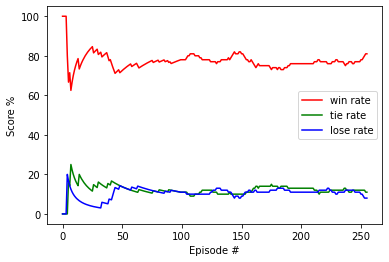

In [270]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(np_scores)), np_scores.T[0], color='r', label='win rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[1], color='g', label='tie rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[2], color='b', label='lose rate')
plt.ylabel('Score %')
plt.xlabel('Episode #')
plt.legend(loc='best')
plt.show()

In [52]:
f = file.open()

NameError: name 'file' is not defined